# You can read this document as a report or if you want to see code details just click the button.

In [1]:
from IPython.display import HTML

HTML('''
<script>code_show=true; 

function code_toggle() {
    if (code_show){
    $('div.input').hide();
    } else {
    $('div.input').show();
    }
    code_show = !code_show
} 

$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to show or hide your raw code."></form>
''')

# Introduction

Spain has the environmental commitment to reach at least 32% of energy consumption from renewable sources by the year 2030, where **wind power** is the main source of clean energy. The energy market requires **hourly planning of energy generation**,is therefore essential to have forecasting tools that are as accurate and reliable as possible, due to supply and cost depend on it. **Recurrent neural network models** have been proposed as a solution to different problems of time series in many fields, however, despite making accurate forecasts, they **lack a measure of model uncertainty.** To mitigate this disadvantage, different methodologies have been proposed recently. In this project a **Bayesian Long Short Term Memory (LSTM) Neural Network model** is explored, following the **Montecarlo Dropout methodology**, for the prediction of one step forward in the hourly generation of wind power in Spain with **uncertainty estimation**.

***Key Words***: Bayesian Long Short Term Memory (LSTM) Neural Network, Model Uncertainty, Montecarlo Dropout, Wind Power Generation.

# ***Data description***

The data were taken from the Spain's Electric Network page (<a href="https://demanda.ree.es/visiona/home">https://demanda.ree.es/visiona/home</a>); for the purpose of this project, data from January 01/2014 to December 31/2019 were downloaded. Once the data were transformed and cleaned up, we divide the dataset in train and validation sets, letting the first five years for train and 2019 to validation as shown in the figure below.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [3]:
# Reading the data
data = np.load('data.npz')
train = data['train']
validation = data['validation']

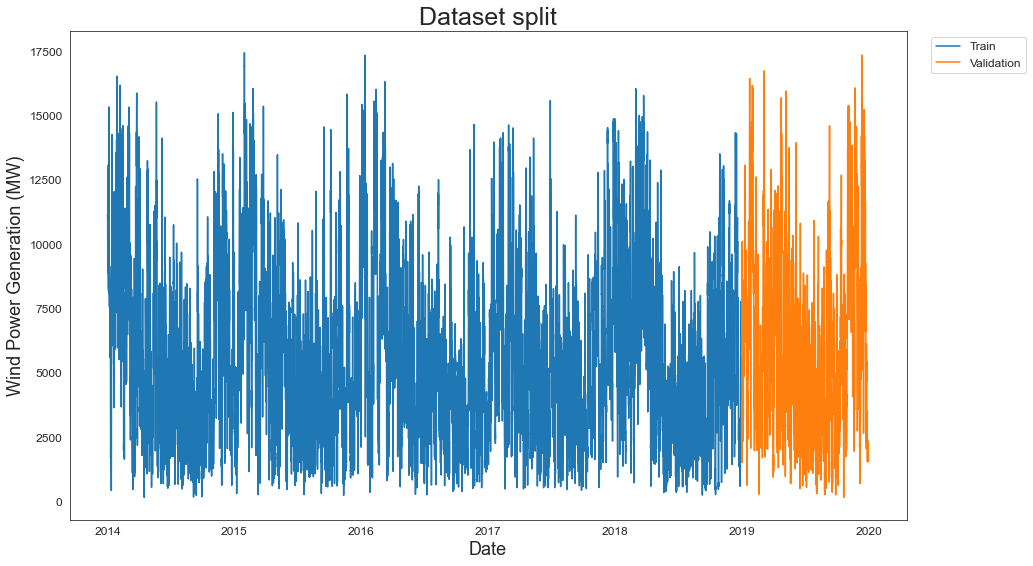

In [4]:
# Plotting the data

date_plot_train = pd.date_range('2014-01-01', periods=len(train), freq='H')
df_plot_train = pd.DataFrame()
df_plot_train['Date'] = date_plot_train
df_plot_train['Set'] = 'Train'
df_plot_train['Wind Power Generation (MW)'] = train.reshape(-1,1)

date_plot_validation = pd.date_range('2019-01-01', periods=len(validation), freq='H')
df_plot_validation = pd.DataFrame()
df_plot_validation['Date'] = date_plot_validation
df_plot_validation['Set'] = 'Validation'
df_plot_validation['Wind Power Generation (MW)'] = validation.reshape(-1,1)

df_plot = pd.concat([df_plot_train,df_plot_validation], axis=0)

plt.figure(figsize=(15, 9))
sns.set_style("white")
plt.title('Dataset split', fontsize= 25)
plt.xlabel('Date',fontsize = 18)
plt.ylabel('Wind Power Generation (MW)',fontsize = 18)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
g = sns.lineplot(x="Date", y="Wind Power Generation (MW)", hue='Set',
                     data=df_plot)
g.legend(loc='upper right',bbox_to_anchor=(1.15, 1.0),fontsize = 12);

Taking apart the validation set, we looked over the trainning set to find some insigths about the data. As a first look we described the data and ploted the distribution.

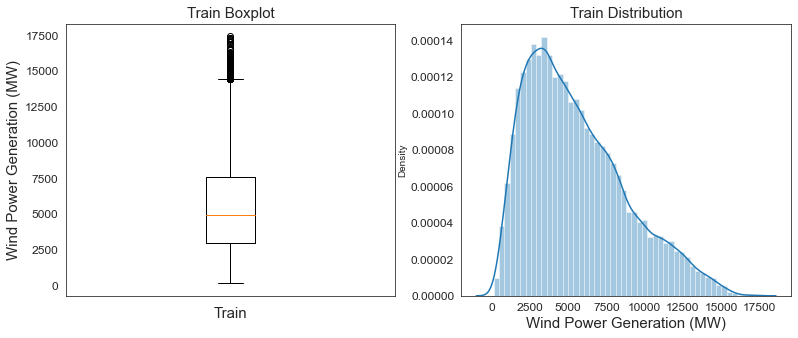

In [5]:
#Plotting the data distribution

plt.figure(figsize=(13, 5))
plt.subplot(121)
plt.title('Train Boxplot', fontsize = 15)
plt.xlabel('Train', fontsize = 15)
plt.xticks([0])
plt.yticks(fontsize = 12)
plt.ylabel('Wind Power Generation (MW)',fontsize = 15)
plt.boxplot(train)
plt.subplot(122)
plt.title('Train Distribution', fontsize = 15)
plt.xlabel('Wind Power Generation (MW)',fontsize = 15)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
sns.distplot(train);

In [6]:
df = pd.DataFrame(data=train, columns=["Train Description"])
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Train Description,43824.0,5541.249314,3262.559321,147.833,2966.95825,4916.5,7564.54175,17435.833


Exploratory analysis shows that the data has an assimetric distribution, however, its difficult to say if we have an outlier despite the boxplot, in my opinion the data is clean and we can move on to the next step.

# **Wind Power Prediction with Bayesian LSTM Neural Network**


LSTM Neural Networks are a special type of Recurrent Neural Networks (RNN), that have been used succesfully as solution of many problems, due to they memorize long term dependencies, controlling the information that flows along each memory cell, preventing the vanishing gradient problem.

Despite the high performance that deep learning models evince in predictive problems, they have some limitations about model uncertainty estimation. However, as shown in "Deep and Confident Prediction for time Series at Uber", Bayesian Neural Networks are nowadays considered as the main approach to get over this limitation, **estimating model uncertainty from a Bayesian perspective.**

Bayesian probability offers a mathematical ground to integrate uncertainty to deep learning models, however, it is usual that the proposed inference methods, mostly variational inference, lead to high computational cost. In contrast, in "Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning.", authors show how to **Dropout can be interpreted as an approximation to the Gaussian Process**, with the advantage that no changes are required in the neural network architecture and can be applied directly to the trained model, without sacrificing computational cost or model performance. Authors named this method as **Monte Carlo Dropout**, and it is the approach that we follow in this project.

The **BayesianLSTM Class** contains the functions that define the proposed methodology: 

* create_dataset: creates data X,Y from a time serie where X contains subseries of the orginal one with a lookback window, and Y is the next step after the window lookback.
* fit_model: takes X,Y and fit the LSTM Neural Network.
* bayesian_predict: predicts the model output using the Monte Carlo Dropout methodology.
* bayesianLSTM_plot: plots the model output, showing confident intervals of each prediction.

In [7]:
import time
import tensorflow as tf
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras.layers.core import Dropout
from tensorflow.python.keras.layers.core import Activation
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input

In [8]:
class BayesianLSTM():
 
    def __init__(self):

        self.look_back = 1
        self.batch_size = 1
        self.num_lstm = 1
        self.input_data = []
        self.output_data = []

    def create_dataset(self, serie, look_back):
        
        '''
        Transforms a time serie T into a X,Y series where X contains subseries of T with a lookback window and 
        Y is the step forward after the lookback window.
        
        Input:
        
            serie (array): Time serie.
            look_back (int): Temporary window size.
        
        Output:
        
            dataset (array): Returns X and Y.
        
        '''

        self.look_back = look_back
        dataX, dataY = [], []
        for i in range(len(serie) - look_back):
            a = serie[i:(i + look_back), 0]
            dataX.append(a)
            dataY.append(serie[i + look_back, 0])

        self.input_data = np.array(dataX)
        self.output_data = np.array(dataY)

        return self.input_data, self.output_data

    def fit_model(self, x, y, num_lstm, epochs, neurons1, neurons2, neurons3,dropout):
        
        '''
        fit_model trains the LSTM neural network.
        
        Input:
        
            x (array): Input data to train the model, X is the output of create_dataset function.
            y (array): Target Y, comes from create_dataset function.
            num_lstm (int): Layers to be set in the LSTM neural netowrk model, between 1 to 3.
            epochs: Number of epoch.
            neurons1 (int): Number of neurons to be set in the first layer of LSTM neural network.
            neurons2 (int): Number of neurons to be set in the second layer of LSTM neural network. 
            neurons3 (int): Number of neurons to be set in the third layer of LSTM neural network.
            dropout (float): Number between 0 and 1, to bet set as dropout.
            
        Output:
        
            Trained LSTM neural network model.
        
        '''
        
        self.num_lstm == num_lstm
        batch_size = 1

        x = x.reshape(x.shape[0], 1, x.shape[1])

        
        input = Input(batch_shape=(batch_size, x.shape[1], x.shape[2]))
        lstm1 = LSTM(neurons1, batch_input_shape=(batch_size, x.shape[1], x.shape[2]),
                     stateful=True, 
                     activation="tanh", recurrent_activation="sigmoid",
                     bias_initializer = "ones",
                     kernel_initializer="random_normal")(input)  
        drop = Dropout(dropout)(lstm1, training=True)

        if self.num_lstm >= 2:
            
            lstm2 = LSTM(neurons2, batch_input_shape=(batch_size, x.shape[1], x.shape[2]),
                         stateful=True,
                         activation="tanh", recurrent_activation="sigmoid",
                         kernel_initializer="random_normal")(drop)
            drop = Dropout(dropout)(lstm2, training=True)
            
            if self.num_lstm == 3:
                
                lstm3 = LSTM(neurons3, batch_input_shape=(batch_size, x.shape[1], x.shape[2]),
                             stateful=True,
                             activation="tanh", recurrent_activation="sigmoid",
                             kernel_initializer="random_normal")(drop)
                drop = Dropout(dropout)(lstm3, training=True)

        dense1 = Dense(1)(drop)
        out = Activation('relu')(dense1)

        model = Model(inputs=input, outputs=out)
        model.compile(loss='mse', optimizer='adam', metrics=['mse', 'mape'])
        num_epoch = epochs

        for i in range(num_epoch):
            print('epoch:',i)
            model.fit(x, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
            model.reset_states

        return model

    
       
    def bayesian_predict(self, x, n_experiments, model, transform):
        
        '''
        Predicts results from the LSTM model using the Monte Carlo Dropout methodology; returns a dataframe with the mean,
        median and standard deviation of each predictive experiment.
         
        
        Input:
        
            x (array): Time serie data.
            n_experiments (int): Number of predictive experiments of X to estimate the mean, median and standard deviation. 
            model: trained LSTM neural network model.
            transform: MinMaxScaler function used in the data transformation before train the LSTM neural network.
            
        Output:
        
            prediction_df (Dataframe): Dataframe with the mean, median and standard deviation of each predictive experiment of X.
         
        
        '''
        
        prediction_df = pd.DataFrame()
        prediction_df['index'] = range(len(x))
        x = x.reshape(x.shape[0], 1, x.shape[1])

        for i in range(n_experiments):
            experiment_predictions = model.predict(x, self.batch_size)
            des_scaled = transform.inverse_transform(experiment_predictions)
            prediction_df['generation_{}'.format(i)] = des_scaled

        df_generation = prediction_df.filter(like='generation', axis=1)
        prediction_df['generation_mean'] = df_generation.mean(axis=1)
        prediction_df['generation_median'] = df_generation.median(axis=1)
        prediction_df['generation_std'] = df_generation.std(axis=1)
        prediction_df = prediction_df[['generation_mean', 'generation_median', 'generation_std']]

        return prediction_df


    def bayesianLSTM_plot(self, real, y_predicted, init_date, title):
            
            '''
            Plots the comparison between test and predicted data. Predicted data includes the estimate uncertainty of the model,
            shown as the confident intervals calculated by two and three times the standard deviation.
            
            Input:
            
                real: Testing data
                y_predicted: Estimation of testing data.
            
            '''
            
            bayes_predicted = pd.DataFrame()
            bayes_predicted['generation_mean'] = np.array(y_predicted.iloc[0:, 0])
            bayes_predicted['generation_median'] = np.array(y_predicted.iloc[0:, 1])
            bayes_predicted['generation_std'] = np.array(y_predicted.iloc[0:, 2])

            date_plot = pd.date_range(init_date, periods=len(bayes_predicted), freq='H')
            df_mean_pred = pd.DataFrame()
            df_median_pred = pd.DataFrame()
            
            # mean predicted df 
            df_mean_pred['Date'] = date_plot
            df_mean_pred['Data'] = 'Prediction (Mean)'
            df_mean_pred['Wind Power Generation (MW)'] = np.array(bayes_predicted['generation_mean'])
            
            # median predicted df 
            df_median_pred['Date'] = date_plot
            df_median_pred['Data'] = 'Prediction (Median)'
            df_median_pred['Wind Power Generation (MW)'] = np.array(bayes_predicted['generation_median'])

            # real df
            df_plot_real = pd.DataFrame()
            df_plot_real['Date'] = date_plot
            df_plot_real['Data'] = 'Real'
            df_plot_real['Wind Power Generation (MW)'] = np.array(real)

            # plot df

            df_plot = pd.concat([df_plot_real,
                                 df_mean_pred,
                                 df_median_pred], axis=0)

            # plot error

            error_df = pd.DataFrame()
            error_df['Date'] = date_plot
            error_df['lower_bound'] = np.array(bayes_predicted['generation_mean'] - 3 * bayes_predicted['generation_std'])
            error_df['upper_bound'] = np.array(bayes_predicted['generation_mean'] + 3 * bayes_predicted['generation_std'])
            error_df['middle_lower_bound'] = np.array(bayes_predicted['generation_mean'] - 2 * bayes_predicted['generation_std'])
            error_df['middle_upper_bound'] = np.array(bayes_predicted['generation_mean'] + 2 * bayes_predicted['generation_std'])
            
            
            lower_corrected = [0 if x < 0 else x for x in error_df['lower_bound']]
            error_df['lower_bound'] = np.array(lower_corrected)
            
            middle_lower_corrected = [0 if x < 0 else x for x in error_df['middle_lower_bound']]
            error_df['middle_lower_bound'] = np.array(middle_lower_corrected)
            
                      
            plt.figure(figsize=(17, 9))
            sns.set_style("white")
            plt.title(title, fontsize= 25)
            plt.xlabel('Date',fontsize = 18)
            plt.ylabel('Wind Power Generation (MW)',fontsize = 18)
            plt.xticks(fontsize= 12)
            plt.yticks(fontsize= 12)
            
            plt.fill_between(error_df.Date, error_df.lower_bound, error_df.middle_lower_bound,
                             color='gray', alpha=0.10)
                        
            plt.fill_between(error_df.Date, error_df.middle_lower_bound, error_df.middle_upper_bound,
                             color='gray', alpha=0.15)
            
            plt.fill_between(error_df.Date, error_df.middle_upper_bound, error_df.upper_bound,
                             color='gray', alpha=0.10)
            
           
            g = sns.lineplot(x='Date', y='Wind Power Generation (MW)', hue='Data', style="Data",
                         data=df_plot)
            g.legend(loc='upper right',bbox_to_anchor=(1.175, 1.0),fontsize = 12)
            

# Training the model

As first step, we have to transform the data to be able to feed the neural network because it is mandatory that the range of the data to be between 0 and 1. Once this is done, we use the bayesianLSTM Class, particulary the **create_dataset** function, to transform the original arrays to the ones that finally will be used to train the model. Then, we fit the **LSTM neural network** with the training data as seen below.

In [9]:
from sklearn import preprocessing

#Scaling the data to train the LSTM neural network

scaler = preprocessing.MinMaxScaler()
scaler = scaler.fit(train.reshape(-1,1))

train_input = scaler.transform(train.reshape(-1,1))
validation_input = scaler.transform(validation.reshape(-1,1))

bayes = BayesianLSTM()

x, y = bayes.create_dataset(np.concatenate((train_input,validation_input)), 1)
x_train, y_train = x[:-len(validation_input)], y[:-len(validation_input)] 
x_validation, y_validation = x[-len(validation_input):], y[-len(validation_input):]


In [10]:
#Training the model
#In this case, we use a LSTM neural network with 2 lstm layers, 32 and 16 neurons each, and dropout 0.15, trained along 100 epochs.

t_0 = time.time()
model = bayes.fit_model(x = x_train, y = y_train, num_lstm = 1, epochs= 100, neurons1 = 32, neurons2 = 16, neurons3 = 0,dropout= 0.15) 
t_1 = time.time()
print('Training time (min): ',round((t_1 - t_0)/60,2))

epoch: 0
43823/43823 [==============================] - 45s 1ms/step - loss: 0.0388 - mse: 0.0388 - mape: 39.9207
epoch: 1
43823/43823 [==============================] - 46s 1ms/step - loss: 7.1894e-04 - mse: 7.1894e-04 - mape: 9.9410
epoch: 2
43823/43823 [==============================] - 47s 1ms/step - loss: 5.8216e-04 - mse: 5.8216e-04 - mape: 9.0447
epoch: 3
43823/43823 [==============================] - 47s 1ms/step - loss: 5.8857e-04 - mse: 5.8857e-04 - mape: 446.0573
epoch: 4
43823/43823 [==============================] - 46s 1ms/step - loss: 6.0520e-04 - mse: 6.0520e-04 - mape: 9.1285
epoch: 5
43823/43823 [==============================] - 49s 1ms/step - loss: 5.9544e-04 - mse: 5.9544e-04 - mape: 421.4355
epoch: 6
43823/43823 [==============================] - 47s 1ms/step - loss: 5.6514e-04 - mse: 5.6514e-04 - mape: 8.9793
epoch: 7
43823/43823 [==============================] - 48s 1ms/step - loss: 5.8485e-04 - mse: 5.8485e-04 - mape: 30.3120
epoch: 8
43823/43823 [============

43823/43823 [==============================] - 49s 1ms/step - loss: 5.0204e-04 - mse: 5.0204e-04 - mape: 8.6472
epoch: 67
43823/43823 [==============================] - 50s 1ms/step - loss: 5.1822e-04 - mse: 5.1822e-04 - mape: 8.8209
epoch: 68
43823/43823 [==============================] - 50s 1ms/step - loss: 5.2250e-04 - mse: 5.2250e-04 - mape: 505.5182
epoch: 69
43823/43823 [==============================] - 50s 1ms/step - loss: 5.3414e-04 - mse: 5.3414e-04 - mape: 805.6374
epoch: 70
43823/43823 [==============================] - 50s 1ms/step - loss: 5.3674e-04 - mse: 5.3674e-04 - mape: 8.8198
epoch: 71
43823/43823 [==============================] - 50s 1ms/step - loss: 5.5181e-04 - mse: 5.5181e-04 - mape: 8.8888
epoch: 72
43823/43823 [==============================] - 50s 1ms/step - loss: 5.6002e-04 - mse: 5.6002e-04 - mape: 8.9740
epoch: 73
43823/43823 [==============================] - 50s 1ms/step - loss: 5.6587e-04 - mse: 5.6587e-04 - mape: 8.9570
epoch: 74
43823/43823 [=======

# Testing the model

So far, there has been nothing different about the usual LSTM neural network training process. Now, we can see that the **bayesian_predict** function has the **n_experiments parameter**; the **Monte Carlo Dropout methodology**, asumes the prediction as the repetion of N predictive experiments, where Dropout is activated with a probability p in each layer, this way a sample is generated with N experiments, 100 in our case, and **uncertainty can be approximated throught the sample variance and the prediction it is obtained with the mean.**

Due to Dropout avoids the information flow in some neurons intentionally, it is possible that results with a high standard deviation will be generated, this is why in many cases, using the median leads better results for predictions instead of the mean. Both will be observed to determine which is better for the purpose of the project.

In [11]:
y_hat_validation = bayes.bayesian_predict(np.concatenate((x_train,x_validation)), 100, model = model, transform= scaler)
y_hat_validation

,generation_mean,generation_median,generation_std
0,9821.909180,9822.542969,1484.637573
1,13034.083984,13194.578125,1070.470825
2,12729.504883,12787.286133,939.599426
3,7960.691895,7935.064453,328.443298
4,10623.847656,10676.032227,503.507446
...,...,...,...
52578,1693.541138,1682.386475,270.198792
52579,1637.542236,1633.399170,301.437378
52580,1670.490723,1655.501953,296.951416
52581,1525.902954,1519.755615,300.581573


In the graphics below, we can observe the adjustment of the model. Graphics describe the test values, and its predictions with **mean and median**. Also, we can see the **confidence intervals**, which generated with the mean plus 2 and 3 standard deviations representing the **95% and 99% confidence level respectively.**

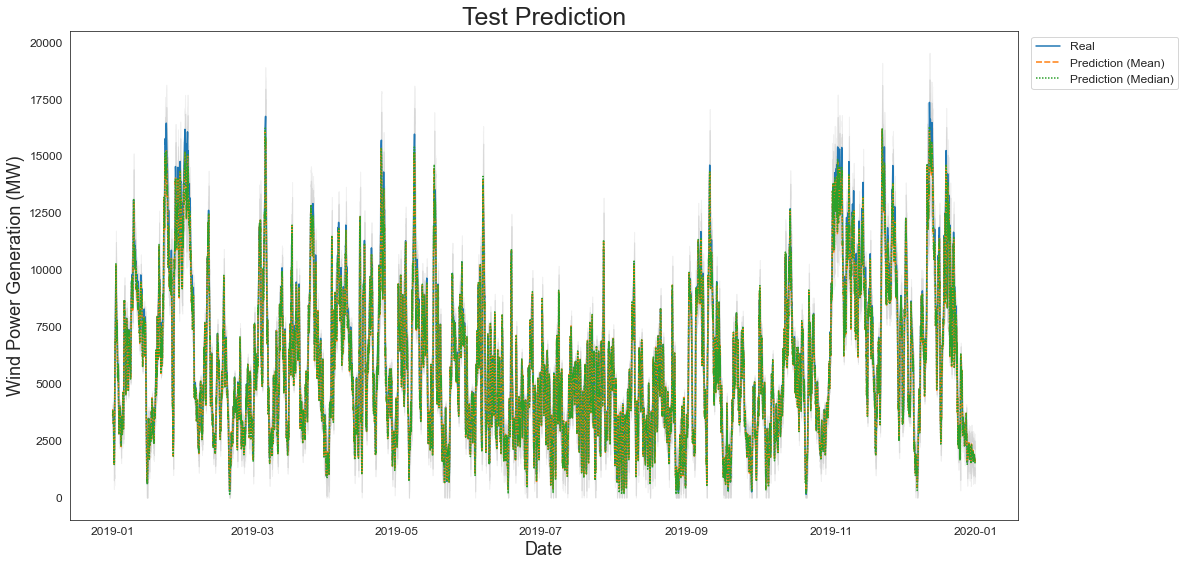

In [12]:
bayes.bayesianLSTM_plot(validation[-len(validation):],y_hat_validation.iloc[-len(validation):],'2019-01-01','Test Prediction')

For better appreciation of the quality of the approximation and the boundaries of the confidence intervals, we zoom the graphic in the **last week of the test data.**

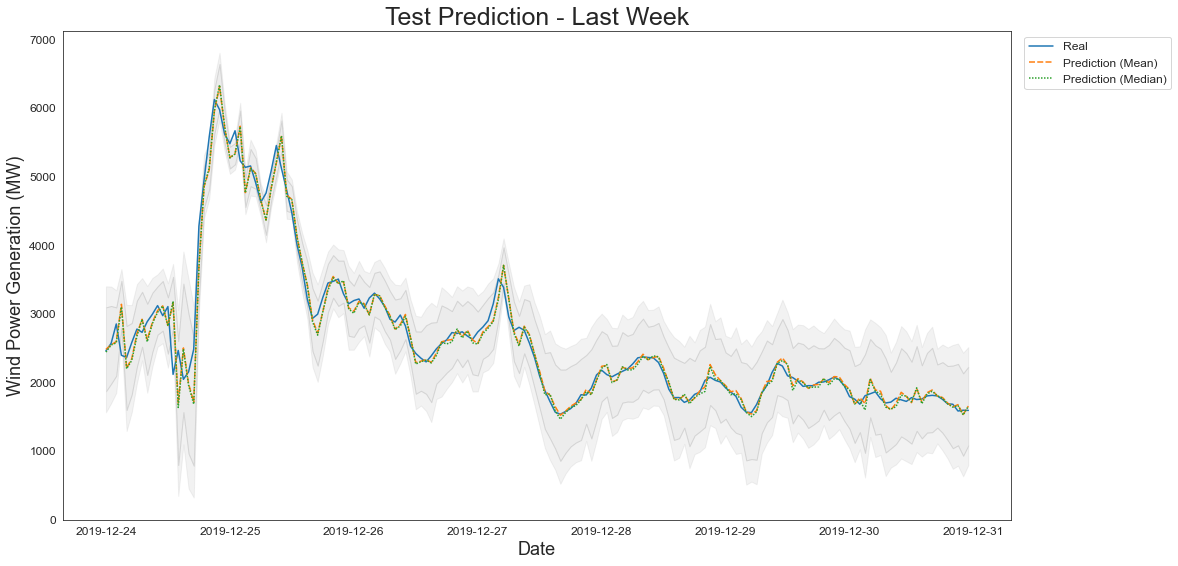

In [13]:
bayes.bayesianLSTM_plot(validation[-168:],y_hat_validation.iloc[-168:],'2019-12-24','Test Prediction - Last Week')

As seen in the graphics above, the model seems to be doing it well; we will confirm this in the next section.

# **Model Metrics**


We use the **RMSE, MAE and MAPE errors** to measure the difference between the predicted values and the values observed. Also we use the **empirical coverage** as sugested by the "Deep and Confident Prediction for Time Series at Uber" paper to evaluate the quality of the uncertainty estimation.

In [14]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

class Metrics():

  def __init__(self):
    pass

  def rmse(real, predicted):
    return sqrt(mean_squared_error(real, predicted))

  def mape(real, predicted): 
    return np.mean(np.abs((real - predicted) / real)) * 100

  def mae(real, predicted):
    return mean_absolute_error(real, predicted)

In [15]:
#Performance using the mean estimation

rmse = Metrics.rmse(validation, np.array(y_hat_validation.iloc[-len(validation):,0].values))
mae = Metrics.mae(validation, np.array(y_hat_validation.iloc[-len(validation):,0].values))
mape = Metrics.mape(validation, np.array(y_hat_validation.iloc[-len(validation):,0].values))
print('Performance using the mean')
print('RMSE: {}   MAE: {}    MAPE: {}'.format(rmse,mae,mape))

Performance using the mean
RMSE: 400.6540762328887   MAE: 285.7932788552898    MAPE: 5.257443157627817


In [16]:
#Performance using the median estimation

rmse = Metrics.rmse(validation, np.array(y_hat_validation.iloc[-len(validation):,1].values))
mae = Metrics.mae(validation, np.array(y_hat_validation.iloc[-len(validation):,1].values))
mape = Metrics.mape(validation, np.array(y_hat_validation.iloc[-len(validation):,1].values))
print('Performance using the median')
print('RMSE: {}   MAE: {}    MAPE: {}'.format(rmse,mae,mape))

Performance using the median
RMSE: 390.6463243278777   MAE: 280.7640556494447    MAPE: 5.228724675572064


In [17]:
#Calculating empirical coverage

bounds_df = pd.DataFrame()

bounds_df['lower_bound'] = y_hat_validation.iloc[-len(validation):,0] - 3*y_hat_validation.iloc[-len(validation):,2]
bounds_df['upper_bound'] = y_hat_validation.iloc[-len(validation):,0] + 3*y_hat_validation.iloc[-len(validation):,2]
bounds_df['real'] = np.array(validation)
bounds_df['contained'] = ((bounds_df['real'] >= bounds_df['lower_bound']) &
                          (bounds_df['real'] <= bounds_df['upper_bound']))

print("Proportion of points contained within 99% confidence interval:", 
      bounds_df['contained'].mean())

Proportion of points contained within 99% confidence interval: 0.8996575342465754


As suggested before, it was possible to get better performance if median was used instead of mean for predictions as in this case; however no big differences are seen. On the other hand, we obtained an 89,9% uncertainty coverage.

# Conclusions

Neural network models like others machine learning models are considered as black boxes due to its lack of interpretability; also the difficult to estimate the uncertainty and the need to large volumes of data to train a model, are very critized aspects of this type of models; thats why exploring new techniques that mitigate this weak aspects are important in order to enhace, even more, the powerfull capability of prediction and the attributes that all we know about of neural network models.

We use the Monte Carlo Dropout methodology, supported by recent studies, that are looking for endow neural network models to the capability of estimate uncertainty and thus increase the trust of the model's predictions. We could appreciate this methodology achieves that purpose with an easy implementation and without any added cost to the neural network training process.